# SciPy 2021 Tutorial <br>_Fairness in AI systems: <br>From social context to practice using Fairlearn_

---

_SciPy 2021 Tutorial: Fairness in AI systems: From social context to practice using Fairlearn by Manojit Nandi, Miroslav Dudík, Triveni Gandhi, Lisa Ibañez, Adrin Jalali, Michael Madaio, Hanna Wallach, Hilde Weerts is licensed under
[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)._

---

Fairness in AI systems is an interdisciplinary field of research and practice that aims to understand and address some of the negative impacts of AI systems on society. In this tutorial, we will walk through the process of assessing and mitigating fairness-related harms in the context of the U.S. health care system. This tutorial will consist of a mix of instructional content and hands-on demonstrations using Jupyter notebooks. Participants will use the Fairlearn library to assess ML models for performance disparities across different racial groups and mitigate those disparities using a variety of algorithmic techniques.

# **Prepare environment**

## Install packages

Note that the runtime environment needs to be restarted after installing `model-card-toolkit`.

In [ ]:
!pip install --upgrade fairlearn==0.7.0
!pip install --upgrade scikit-learn
!pip install --upgrade seaborn
!pip install model-card-toolkit

## Import and set up packages

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.3f}".format)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    plot_roc_curve)
from sklearn import set_config

set_config(display="diagram")

In [4]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

In [5]:
# Model Card Toolkit works in Google Colab, but it does not work on all local environments
# that we tested. If the import fails, define a dummy function in place of the function
# for saving figures into images in a model card..

try:
    from model_card_toolkit import ModelCardToolkit
    from model_card_toolkit.utils.graphics import figure_to_base64str
    model_card_imported = True
except Exception:
    model_card_imported = False
    def figure_to_base64str(*args):
        return None

In [6]:
from IPython import display
from datetime import date

# **Overview of fairness in AI systems**

Please refer to the slides here: https://raw.githubusercontent.com/fairlearn/talks/main/2021_scipy_tutorial/overview.pdf



# **Introduction of Fairlearn and other tutorial resources**


This tutorial builds on the following open source projects:

* **machine learning and data processing**: _scikit-learn_, _pandas_, _numpy_
* **plotting**: _seaborn_, _matplotlib_
* **AI fairness**: _Fairlearn_, _Model Card Toolkit_

### [Fairlearn](https://fairlearn.org)

Fairlearn is an open-source, community-driven project to help data scientists improve fairness of AI systems. It includes:

* A Python library for fairness assessment and improvement (fairness metrics, mitigation algorithms, plotting, etc.)

* Educational resources covering organizational and technical processes for unfairness mitigation (user guide, case studies, Jupyter notebooks, etc.)

The project was started in 2018 at Microsoft Research. In 2021 it adopted neutral governance structure and since then it is completely community-driven.

### [Model Card Toolkit](https://github.com/tensorflow/model-card-toolkit)

The Model Card Toolkit (MCT) streamlines and automates generation of _model cards_, machine learning documents that provide context and transparency into a model's development and performance. It was released by Google in 2020.

# **Introduction to the health care scenario**

Our scenario builds on previous research that highlighted racial disparities in how health care resources are allocated in the U.S. ([Obermeyer et al., 2019](https://science.sciencemag.org/content/366/6464/447.full)).
Motivated by that work, in this tutorial we consider an automated system for recommending patients for _high-risk care management_ programs, which are described by Obermeyer et al. 2019 as follows:

> These programs seek to improve the care of patients with complex health needs by providing additional resources, including greater attention from trained providers, to help ensure that care is well coordinated. Most health systems use these programs as the cornerstone of population health management efforts, and they are widely considered effective at improving outcomes and satisfaction while reducing costs. [...] Because the programs are themselves expensive—with costs going toward teams of dedicated nurses, extra primary care appointment slots, and other scarce resources—**health systems rely extensively on algorithms to identify patients who will benefit the most.**

**Convenience restriction**

* In practice, the modeling of health needs would use large data sets covering a wide range of diagnoses. In this tutorial, we will work with a [publicly available clinical dataset](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that focuses on _diabetic patients only_ ([Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/)).

## Dataset and task

We will be working with a clincial dataset of hospital re-admissions over a ten-year period (1998-2008) for diabetic patients across 130 different hospitals in the US. Each record represents the hospital admission records for a patient diagnosed with diabetes whose stay lasted one to fourteen days.

The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

We would like to develop a classification model, which decides whether the patients should be suggested to their primary care physicians for an enrollment into the high-risk care management program. The positive prediction will mean recommendation into the care program.

**Decision point: Task definition**

* A hospital **readmission within 30 days** can be viewed as a proxy that the patients needed more assistance at the release time, so it will be the label we wish to predict.

* Because of the class imbalance, we will be measuring our performance via **balanced accuracy**. Another key performance consideration is how many patients are recommended for care, metric we refer to as **selection rate**.

Ideally, health care professionals would be involved in both designing and using the model, including formalizing the task definition. 


## Fairness considerations

* _Which groups are most likely to be disproportionately negatively affected?_ Previous work suggests that groups with different race and ethnicity can be differently affected.

* _What are the harms?_ The key harms here are allocation harms. In particular, false negatives, i.e., don't recommend somebody who will be readmitted.

* _How should we measure those harms?_


In the remainder of the tutorial we will:
* First examine the dataset and our choice of label with an eye towards a variety of fairness issues.
* Then train a logistic regression model and assess its performance as well as fairness.
* Finally, look at two unfairness mitigation strategies.

<a name="discussion-fairness-issues"></a>
## Discussion: Fairness-related harms

* How can we determine which type of harm is relevant in a particular scenario?
* What are ways to find out which (groups of) individuals are most likely to be disproportionately negatively affected?


# Task definition and dataset characteristics

Two critical decisions when desiging an AI system are
1. how we define the machine learning task
2. what dataset we use to train our models

These choices are often intertwined, because the dataset is often a convenience dataset, based on availability, which leads to a specific choice of label and performance metric (that's also the case in our scenario).

In this part of the tutorial, we first load the dataset, and then we examine it for a variety of fairness issues:
1. sample sizes of different demographic groups, and in particular different racial groups
2. appropriateness of our choice of label (readmission within 30 days)
3. representativeness/informativeness of different features for different groups

Besides dataset characteristics, one additional aspect of dataset fairness is whether the data was collected in a manner that respects the autonomy of individuals in the dataset.

The dataset characteristics can be systematically documented through the **datasheets** practice. We will touch on this later on. By documenting our understanding of the dataset, we communicate any concerns we have about the data and highlight downstream issues that may arise during the model training, evaluation and deployment.



## Load the dataset


We next load the dataset and review the meaning of its columns.


In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/fairlearn/talks/main/2021_scipy_tutorial/data/diabetic_preprocessed.csv")

In [8]:
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,No,No,False,False,False,False,False,NO,0,0
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,Ch,Yes,False,False,False,False,False,>30,1,0
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,No,Yes,False,False,False,True,True,NO,0,0
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,Ch,Yes,False,False,False,False,False,NO,0,0
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,Ch,Yes,False,False,False,False,False,NO,0,0


The columns contain mostly boolean and categorical data (including age and various test results), with just the following exceptions: `time_in_hospital`, `num_lab_procedures`, `num_procedures`, `num_medications`, `number_diagnoses`.


|features| description|
|---|---|
| race, gender, age | demographic features |
| medicare, medicaid | insurance information |
| admission_source_id | emergency, referral, or other |
| had_emergency, had_inpatient_days,<br>had_outpatient_days | hospital visits in prior year |
| medical_specialty | admitting physician's specialty |
| time_in_hospital, num_lab_procedures,<br>num_procedures, num_medications,<br>primary_diagnosis, number_diagnoses,<br>max_glu_serum, A1Cresult, insulin<br>change, diabetesMed | description of the hospital visit<br> |
| discharge_disposition_id | discharched to home or not |
| readmitted, readmit_binary,<br>readmit_30_days | readmission information |




In [9]:
# Show the values of all binary and categorical features
categorical_values = {}
for col in df:
  if col not in {'time_in_hospital', 'num_lab_procedures',
                 'num_procedures', 'num_medications', 'number_diagnoses'}:
    categorical_values[col] = pd.Series(df[col].value_counts().index.values)
categorical_values_df = pd.DataFrame(categorical_values).fillna('')
categorical_values_df.T

,0,1,2,3,4,5
race,Caucasian,AfricanAmerican,Unknown,Hispanic,Other,Asian
gender,Female,Male,Unknown/Invalid,,,
age,Over 60 years,30-60 years,30 years or younger,,,
discharge_disposition_id,Discharged to Home,Other,,,,
admission_source_id,Emergency,Referral,Other,,,
medical_specialty,Missing,Other,InternalMedicine,Emergency/Trauma,Family/GeneralPractice,Cardiology
primary_diagnosis,Other,Respiratory Issues,Diabetes,Genitourinary Issues,Musculoskeletal Issues,
max_glu_serum,None,Norm,>200,>300,,
A1Cresult,None,>8,Norm,>7,,
insulin,No,Steady,Down,Up,,


We mark all categorical features: 

In [10]:
categorical_features = [
    "race",
    "gender",
    "age",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "primary_diagnosis",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "change",
    "diabetesMed",
    "readmitted"
]

In [11]:
for col_name in categorical_features:
  df[col_name] = df[col_name].astype("category")

## Group sample sizes 

From the perspective of fairness assessment, a key data characteristic is the sample size of groups with respect to which we conduct fairness assessment.

Small sample sizes have two implications:

* **assessment**: the impacts of the AI system on smaller groups are harder to assess, because due to fewer data points we have a much larger uncertainty (error bars) in our estimates

* **model training**: fewer training data points mean that our model fails to appropriately capture any data patterns specific to smaller groups, which means that its predictive performance on these groups could be worse

Let's examine the sample sizes of the groups according to `race`:



In [12]:
df["race"].value_counts()

Caucasian          76099
AfricanAmerican    19210
Unknown             2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

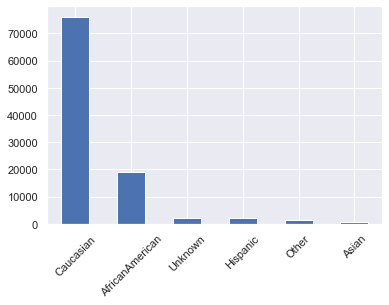

In [13]:
df["race"].value_counts().plot(kind='bar', rot=45);

Normalized as frequencies:

In [14]:
df["race"].value_counts(normalize=True)

Caucasian         0.748
AfricanAmerican   0.189
Unknown           0.022
Hispanic          0.020
Other             0.015
Asian             0.006
Name: race, dtype: float64

In our dataset, our patients are predominantly *Caucasian* (75%). The next largest racial group is *AfricanAmerican*, making up 19% of the patients. The remaining race categories (including *Unknown*) compose only 6% of the data.

We also examine the dataset composition by `gender`:

In [15]:
df["gender"].value_counts() # counts

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [16]:
df["gender"].value_counts(normalize=True) # frequencies

Female            0.538
Male              0.462
Unknown/Invalid   0.000
Name: gender, dtype: float64

Gender is in our case effectively binary (and we have no further information how it was operationalized), with both *Female* represented at 54% and *Male* represented at 46%. There are only 3 samples annotated as *Unknown/Invalid*.

### Decision point: How do we address smaller group sizes?

When the data set lacks coverage of certain groups, it means that we will not be able to reliably assess any fairness-related issues. There are three interventions (which could be carried out in a combination):

* **collect more data**: collect more data for groups with fewer samples
* **buckets**: merge some of the groups
* **drop small groups**

The choice of strategy depends on our existing understanding of which groups are at the greatest risk of a harm. In particular, pooling the groups with widely different risks could mask the extent of harms. We generally caution against dropping small groups as this leads to the representational harm of erasure.

If any groups are merged or dropped, these decisions should be annotated / explained (in the datasheet, which we discuss below).

In our case, we will:

* merge the three smallest race groups *Asian*, *Hispanic*, *Other* (similar to [Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/)), but also retain the original groups for auxiliary assessments

* drop the gender group *Unknown/Invalid*, because the sample size is so small that no meaningful fairness assessment is possible

In [17]:
# drop gender group Unknown/Invalid
df = df.query("gender != 'Unknown/Invalid'")

# retain the original race as race_all, and merge Asian+Hispanic+Other 
df["race_all"] = df["race"]
df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"})

### Exercise

Please examine the distribution of the `age` feature in the dataset.

### Answer

In [18]:
df["age"].value_counts()

Over 60 years          68538
30-60 years            30716
30 years or younger     2509
Name: age, dtype: int64

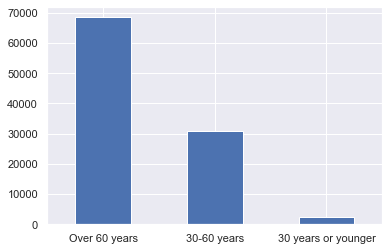

In [19]:
df["age"].value_counts().plot(kind='bar', rot=0);

As we might expect, most patients admitted into the hospital in our data set belong to the *Over 60 years* category. Although we will not be assessing for age-based fairness-related harms in this tutorial, we will want to document the age imbalance in our dataset.

## Examining the choice of label

Next we dive into the question of whether our choice of label (readmission within 30 days) aligns with our goal (identify patients that would benefit from the care management program).

A framework particularly suited for this analysis is called _measurement modeling_ (see, e.g., [Jacobs and Wallach, 2021](https://arxiv.org/abs/1912.05511)). The goal of measurement modeling is to describe the relationship between what we care about and what we can measure. The thing that we care about is referred to as the _construct_ and what we can observe is referred to as the _measurement_. In our case:
* **construct** = greatest benefit from the care management program
* **measurement** = readmission within 30 days (in the absence of such program)

In our case, the **measurement** coincides with the **classification label**.

The act of _operationalizing_ the construct via a specific measurement corresponds to making certain assumptions. In our case, we are making the following assumption: **the greatest benefit from the care management program would go to patients that are** (in the absence of such a program) **most likely to be readmitted into the hospital within 30 days.**

### How can we check whether our assumptions apply?

In the terminology of measurement modeling, how do we establish _construct validity_? Following, [Jacobs and Wallach, 2021](https://arxiv.org/abs/1912.05511),

> Establishing construct
validity means demonstrating, in a variety of ways, that the measurements obtained from measurement model are both meaningful
and useful:
> * Does the operationalization capture all relevant aspects
of the construct purported to be measured?
> * Do the measurements
look plausible?
> * Do they correlate with other measurements of the
same construct? Or do they vary in ways that suggest that the
operationalization may be inadvertently capturing aspects of other
constructs?
> * Are the measurements predictive of measurements of
any relevant observable properties (and other unobservable theoretical constructs) thought to be related to the construct, but not incorporated into the operationalization?

We focus on one aspect of construct validity, called _predictive validity_, which refers to the extent
to which the measurements obtained from a measurement model
are predictive of measurements of any relevant observable properties 
related to the construct purported to be measured, but not incorporated into the operationalization.

The predictions do not need to be chronological, meaning that we do not necessarily need to be predicting future from the past. Also, the predictions do not need to be causal (going from causes to effects). We just need to ensure that the predicted property is not part of the measurement whose validity we're checking.  


### Predictive validity

We would like to show that our measurement `readmit_30_days` is correlated with patient characteristics that are related to our construct "benefiting from care management". One such characteristic is the general patient health, where we expect that patients that are less healthy are more likely to benefit from care management.

While our data does not contain full health records that would enable us to holistically measure general patient health, the data does contain two relevant features: `had_emergency` and `had_inpatient_days`, which indicate whether the patient spent any days in the emergency room or in the hospital (but non-emergency) in the preceding year.

To establish predictive validity, we would like to show that our measurement `readmit_30_days` is predictive of these two observable characteristics.

First, let's check the rate at which the patients with different `readmit_30_days` labels were readmitted in the previous year:

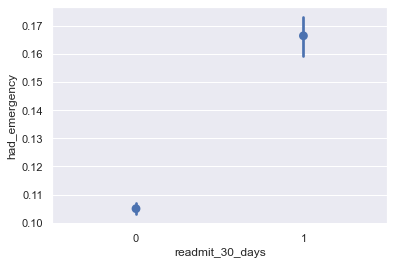

In [20]:
sns.pointplot(y="had_emergency", x="readmit_30_days",
              data=df, ci=95, join=False);

The plot shows that indeed patients with `readmit_30_days=0` have a lower rate of emergency visits in the prior year, whereas patients with `readmit_30_days=1` have a larger rate. (The vertical lines indicate 95% confidence intervals obtained via boostrapping.)

We see a similar pattern when `readmit_30_days` is used to predict the rate of (non-emergency) hospital visits in the previous year:

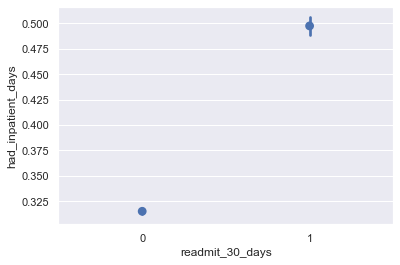

In [21]:
sns.pointplot(y="had_inpatient_days", x="readmit_30_days",
              data=df, join=False);

Now let's take a look whether the predictiveness is similar across different race groups. First, let's check how well `readmit_30_days` predicts `had_emergency`:

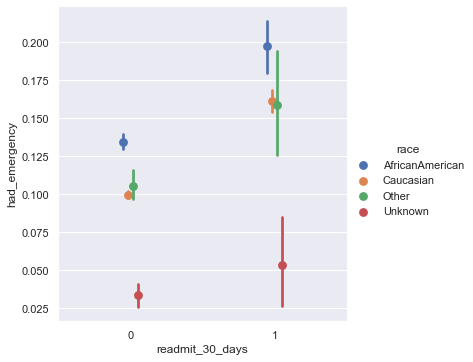

In [22]:
# Visualize predictiveness using a categorical pointplot
sns.catplot(y="had_emergency", x="readmit_30_days", hue="race", data=df,
            kind="point", ci=95, dodge=True, join=False);

The patients in the group *Unknown* have a substantially lower rate of emergency visits in the prior year, regardless of whether they are readmitted in 30 days. The readmission is still positively correlated with `had_emergency`, but note the large error bars (due to small sample sizes).

We also see that the group with feature value *AfricanAmerican* has a higher rate of emergency visits compared with other groups. However, generally the groups *Caucasian*, *AfricanAmerican* and *Other* follow similar dependence patterns.

We see a similar pattern when `readmit_30_days` is used to predict the rate of (non-emergency) hospital visits in the previous year:

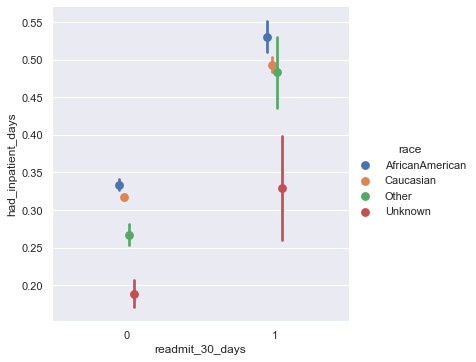

In [23]:
sns.catplot(y="had_inpatient_days", x="readmit_30_days", hue="race", data=df,
            kind="point", ci=95, dodge=True, join=False);

Again, for *Unknown* the rate of (non-emergency) hospital visits in the previous year is lower than for other groups.In all groups there is a strong positive correlation between `readmit_30_days` and `had_inpatient_days`.

In all cases, we see that readmission in 30 days is predictive of our two measurements of general patient health.

The analysis is also surfacing the fact that patients with the value of race *Unknown* have fewer hospital visits in the preceding year (both emergency and non-emergency) than other groups. In practice, this would be a good reason to reach out to health professionals to investigate this patient cohort, to make sure that we understand why there is the systematic difference.

Note that we have only investigated _predictive validity_, but there are other important aspects of construct validity which we may want to establish (see [Jacobs and Wallach, 2021](https://arxiv.org/abs/1912.05511)).

<a name="exercise-predictive-validity"></a>
### Exercise

Check the predictive validity with respect to `gender` and `age`. Do you see any differences? Can you form a hypothesis why?

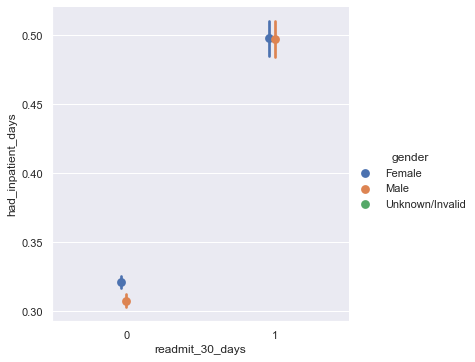

In [24]:
# Check for predictive validity by gender
sns.catplot(y="had_inpatient_days",x="readmit_30_days",hue="gender", data=df,
            kind="point", ci=95, dodge=True, join=False);

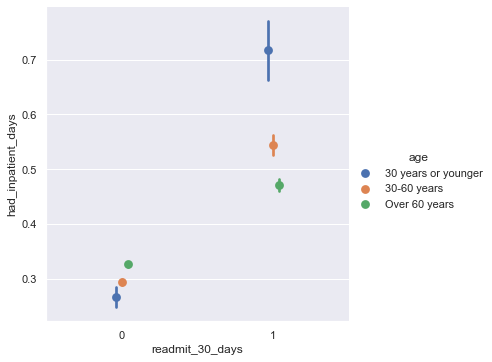

In [25]:
# Check for predictive validity by age
sns.catplot(y="had_inpatient_days", x="readmit_30_days", hue="age", data=df,
            kind="point", ci=95, dodge=True, join=False);

## Label imbalance



Now that we have established the validity of our label, we will check frequency of its values in our data. The frequency of different labels is an important descriptive characteristic in classification settings for several reasons:

* some classification algorithms and performance measures might not work well with data sets with extreme class imbalance
* in binary classification settings, our ability to evaluate error is often driven by the size of the smaller of the two classes (again, the smaller the sample the larger the uncertainty in estimates)
* label imbalance may exacerbate the problems due to smaller group sizes in fairness assessment



Let's check how many samples in our data are labeled as positive and how many as negative.

In [26]:
df["readmit_30_days"].value_counts() # counts

0    90406
1    11357
Name: readmit_30_days, dtype: int64

In [27]:
df["readmit_30_days"].value_counts(normalize=True) # frequencies

0   0.888
1   0.112
Name: readmit_30_days, dtype: float64

As we can see, the target label is heavily skewed towards the patients not being readmitted within 30 days. In our dataset, only 11% of patients were readmitted within 30 days.

Since there are fewer positive examples, we expect that we will have a much larger uncertainty (error bars) in our estimates of *false negative rates* (FNR), compared with *false positive rates* (FPR). This means that there will be larger differences between training FNR and test FNR, even if there is no overfitting, simply because of the smaller sample sizes. 

Our target metric is *balanced error rate*, which is the average of FPR and FNR. The value of this metric is robust to different frequencies of positives and negatives. However, since half of the metric is contributed by FNR, we expect the uncertainty in balanced error values to behave similarly to the uncertainty of FNR.

Now, let's examine how much the label frequencies vary within each group defined by `race`:

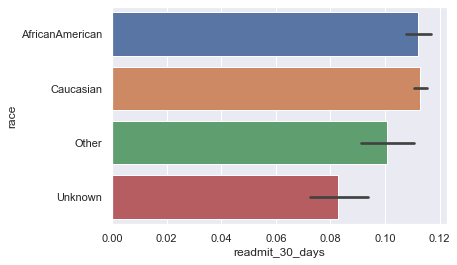

In [28]:
sns.barplot(x="readmit_30_days", y="race", data=df, ci=95);

We see the rate of *30-day readmission* is similar for the *AfricanAmerican* and *Caucasian* groups, but appears smaller for *Other* and smallest for *Unknown* (this is consistent with an overall lower rate of hospital visits in the prior year). The smaller sample size of the *Other* and *Unknown* groups mean that there is more uncertainty around the estimate for these two groups.

## Proxies for sensitive features



We next investigate which of the features are highly predictive of the sensitive feature *race*; such features are called *proxies*.

While in this tutorial we examine fairness issues through the **impact** of the machine-learning model on different populations, there are other concepts of fairness that seek to analyze how the **model might be using information** contained in the sensitive features, and which of the information uses are justified (often using causal reasoning). More pragmatically, certain uses of sensitive features (or proxies of it) might be illegal in some contexts.

Another reason to understand the proxies is because they might explain why we see differences in impact on different groups even when our model does not have access to the sensitive features directly.

In this section we briefly examine the identification of such proxies (but we don't go into legal or causality considerations).


In the United States, *Medicare* and *Medicaid* are joint federal and state programs to help qualified individuals pay for healthcare expenses. *Medicare* is available to people over the age of 65 and younger individuals with severe illnesses. *Medicaid* is available to all individuals under the age of 65 whose adjusted gross income falls below the Federal Poverty Line. 

First, let's explore the relationship between patients who paid with *Medicaid* and our demographic features. Because *Medicaid* is available to low-income individuals, and race is correlated with socioeconomic status in the United States, we expect there to be a relationship between `race` and paying with *Medicaid*. 

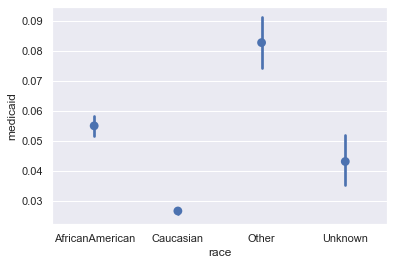

In [29]:
sns.pointplot(y="medicaid", x="race", data=df, join=False);

From our analysis, we see that paying with *Medicaid* does appear to have some relationship with the patient's race. *Caucasian* patients are the least likely to pay with *Medicaid* compared with other groups. If paying with *Medicaid* is a proxy for socioeconomic status, then the patterns we find align with our understanding of wealth and race in the United States.

## Additional validity checks

Similarly as we used predictive validity to check that our label aligns with the construct of "likely to benefit from the care management program", we can use predictive validity to verify that our various features are coherent with each other.

For example, based on the eligibility criteria for *Medicaid* vs *Medicare*, we expect `medicaid` to be negatively correlated with age and `medicare` to be positively correlated with age:

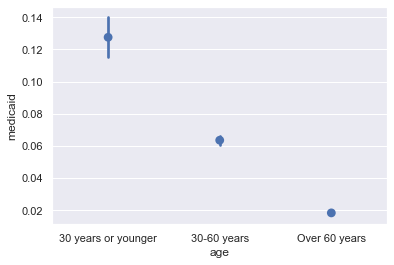

In [30]:
sns.pointplot(y="medicaid", x="age", data=df, ci=95, join=False);

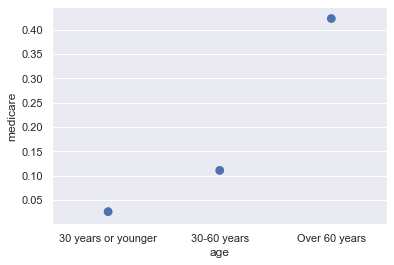

In [31]:
sns.pointplot(y="medicare", x="age", data=df, ci=95, join=False);

As we see, that's indeed the case.

<a name="exercise-dataset"></a>
## Exercise

Now, let's explore the relationship between paying with `medicare` and other demographic features. In the below sections, feel free to perform any analysis you would like to better understand the relationship between `medicare` and `race` and `gender` in this dataset.

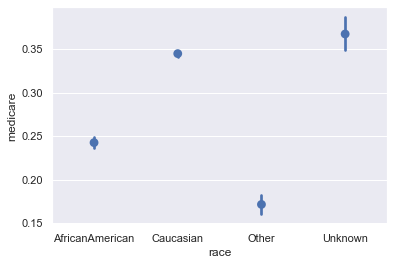

In [32]:
sns.pointplot(y="medicare", x="race", data=df, ci=95, join=False);

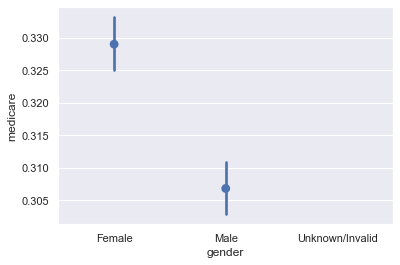

In [33]:
sns.pointplot(y="medicare", x="gender", data=df, ci=95, join=False);

In [ ]:
sns.pointplot(y="medicare", x=____, data=df, ci=95, join=False);

<a name="datasheets"></a>
## Datasheets for datasets

The _datasheets_ practice was proposed by [Gebru et al. (2018)](https://arxiv.org/abs/1803.09010). A datasheet of a given dataset documents the motivation behind the dataset creation, the dataset composition, collection process, recommended uses and many other characteristics. In the words of Gebru et al., the goal is to
> facilitate better communication between dataset creators
> and dataset consumers, and encourage the machine learning
> community to prioritize transparency and accountability.

In this section, we show how to fill in some of the sections of the datasheet for the dataset that we are using. The information is obtained directly from [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/).

### Example sections of a datasheet [OPTIONAL SECTION]

**For what purpose was the dataset created?** *Was there a specific task in mind? Was there a specific gap that needed to be filled?*

In the words of the dataset authors:
> [...] the management of hyperglycemia in the hospitalized patient has a significant bearing on outcome, in terms of both morbidity and mortality. This recognition has led to the development of formalized protocols in the intensive care unit (ICU) setting [...] However, the same cannot be said for most non-ICU inpatient admissions. [...] there are few national assessments of diabetes care in the hospitalized patient which could serve as a baseline for change [in the non-ICU protocols]. The present analysis of a large clinical database was undertaken to examine historical patterns of diabetes care in patients with diabetes admitted to a US hospital and to inform future directions which might lead to improvements in patient safety.

**Who created the dataset (e.g., which team) and on behalf of which entity?**

The dataset was created by [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/): a team of researchers from a variety of disciplines, ranging from computer science to public health, from three institutions (Virginia Commonwealth University, University of Cordoba, and Polish Academy of Sciences).

#### **Composition**

**What do the instances that comprise the dataset represent?**



Each instance in this dataset represents a hospital admission for diabetic patient (diabetes was entered as a possible diagnosis for the patient) whose hospital stay lasted between one to fourteen days.

**Is any information missing from individual instances?**

The features `Payer Code` and `Medical Specialty` have 40,255 and 49,947 missing values, respectively. For `Payer Code`, these missing values are reflected in the category *Unknown*. For `Medical Specialty`, these missing values are reflecting in the category *Missing*. 

For our demographic features, we are missing the `Gender` information for three patients in the dataset. These three records were dropped from our final dataset. Regarding `Race`, the 2,271 missing values were recoded into the `Unknown` race category. 



**Does the dataset identify any subpopulations (e.g., by age, gender)?**

Patients are identified by gender, age group, and race. 

For gender, patients are identified as Male, Female, or Unknown. There were only three instances where the patient gender is *Unknown*, so these records were removed from our dataset.

Gender | Count| Percentage
------ | ------|----------
Male      | 47055     | 46.2%
Female     |  54708     | 53.7%  



For age group, patients are binned into three age buckets: *30 years or younger*, *30-60 years*, *Older than 60 years*.

Age Group |Count| Percentage
------ | ------|----------
30 years or younger      | 2509     | 2.4%
30-60 years       | 30716   | 30.2%
Older than 60 years      |   68538    | 67.4%  


For race, patients are identified as *AfricanAmerican*, *Caucasian*, and *Other*. For individuals whose race information was not collected during hospital admission, their race is listed as *Unknown*.

Race | Count| Percentage
------ | ------|----------
Caucasian      | 76099     | 74.8%
AfricanAmerican     |  19210     | 18.9%  
Other        |     4183         |  4.1%
Unknown        |    2271          | 2.2%

#### **Preprocessing**

**Was any preprocessing/cleaning/labeling of the data done?**

For the `race` feature, the categories of *Asian* and *Hispanic* and *Other* were merged into the *Other* category. The `age` feature was bucketed into 30-year intervals (*30 years and below*, *30 to 60 years*, and *Over 60 years*). The `discharge_disposition_id` was binarized into a boolean outcome on whether an patient was discharged to home.

The full preprocessing code is provided in the file `preprocess.py` of the tutorial [GitHub repository](https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/).




#### **Uses**



**Has the dataset been used for any tasks already?** 

This dataset has been used by [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/) to model the relationship between patient readmission and HbA1c measurement during admission, based on primary medical diagnosis.

The dataset is publicly available through the UCI Machine Learning Repository and, as of May 2021, has received over 350,000 views.

# Training the initial model

We next train a classification model to predict our target variable (readmission within 30 days) while optimizing balanced accuracy.

What kind of model should we train? Deep neural nets? Random forests? Logistic regression?

There are a variety of considerations. We highlight two:

* **Interpretability.** Interpretability is tightly linked with questions of fairness. There are several reasons why it is important to have interpretable models that are open to the stakeholder scrutiny:
  * It allows discovery of fairness issues that were not discovered by the data science team.
  * It provides a path toward recourse for those that are affected by the model.
  * It allows for a *face validity* check, a "sniff test", by experts to verify that the model "makes sense" (at the face value). While this step is subjective, it is really important when the model is applied to different populations than those on which the assessment was conducted.

* **Model expressiveness.** How well can the model separate positive examples from negative examples? How well can it do so given the available dataset size? Can it do so across all groups or does it need to trade off performance on one group against performance on another group?

Some additional considerations are training time (this impacts the ability to iterate), familiarity (this impacts the ability to fine tune and debug), and carbon footprint (this impacts the Earth climate both directly and indirectly by normalizing unnecessarily heavy workloads).

### Decision point: Model type

We will use a logistic regression model. Our reasoning:

* **Interpretability**. Logistic models over a small number of variables (as used here) are highly interpretable in the sense that stakeholders can simulate them easily.

* **Model expressiveness**. Logistic regression predictions are described by a linear weighting of the feature values. The concern might be that this is too simple. The previous work by [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/), which also used a logistic model to predict readmission rates concluded that a slightly more expressive model might be useful (their analysis uncovered 8 pairwise interactions that were significant, see their Table 5).

## Prepare training and test datasets

As we mentioned in the task definition, our target variable is **readmission within 30 days**, and our sensitive feature for the purposes of fairness assessment is **race**.


In [34]:
target_variable = "readmit_30_days"
demographic = ["race", "gender"]
sensitive = ["race"]
# If multiple sensitive features are chosen, the rest of the script considers intersectional groups.

In [35]:
Y, A = df.loc[:, target_variable], df.loc[:, sensitive]

We next drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies").

In [36]:
X = pd.get_dummies(df.drop(columns=[
    "race",
    "race_all",
    "discharge_disposition_id",
    "readmitted",
    "readmit_binary",
    "readmit_30_days"
]))

In [37]:
X.head() # sanity check

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,...,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,1,False,False,False,False,False,...,1,0,0,1,0,0,0,1,1,0
1,3,59,0,18,9,False,False,False,False,False,...,1,0,0,0,0,1,1,0,0,1
2,2,11,5,13,6,False,False,False,True,True,...,1,0,0,1,0,0,0,1,0,1
3,2,44,1,16,7,False,False,False,False,False,...,1,0,0,0,0,1,1,0,0,1
4,1,51,0,8,5,False,False,False,False,False,...,1,0,0,0,1,0,1,0,0,1


We split our data into a training and test portion. The test portion will be used to evaluate our performance metric (i.e., balanced accuracy), but also for fairness assessment. The split is half/half for training and test to ensure that we have sufficient sample sizes for fairness assessment.

In [38]:
random_seed = 445
np.random.seed(random_seed)

In [39]:
X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

Our performance metric is **balanced accuracy**, so for the purposes of training (but not evaluation!) we will resample the data set, so that it has the same number of positive and negative examples. This means that we can use estimators that optimize standard accuracy (although some estimators allow the use us importance weights).


Because we are downsampling the number of negative examples, we create a training dataset with a significantly lower number of data points. For more complex machine learning models, this lower number of training data points may affect the model's accuracy.

In [40]:
def resample_dataset(X_train, Y_train, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

In [41]:
X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

## Save descriptive statistics of training and test data

We next evaluate and save descriptive statistics of the training dataset. These will be provided as part of _model cards_ to document our training.

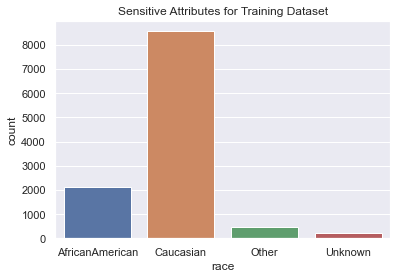

In [42]:
sns.countplot(x="race", data=A_train_bal)
plt.title("Sensitive Attributes for Training Dataset")
sensitive_train = figure_to_base64str(plt)

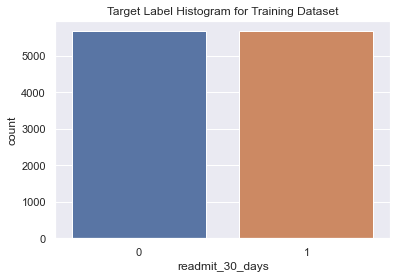

In [43]:
sns.countplot(x=Y_train_bal)
plt.title("Target Label Histogram for Training Dataset")
outcome_train = figure_to_base64str(plt)

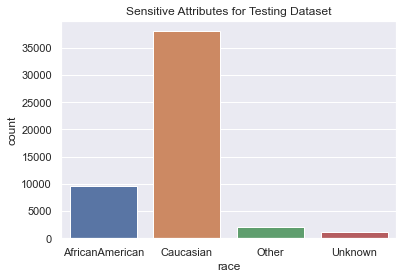

In [44]:
sns.countplot(x="race", data=A_test)
plt.title("Sensitive Attributes for Testing Dataset")
sensitive_test = figure_to_base64str(plt)

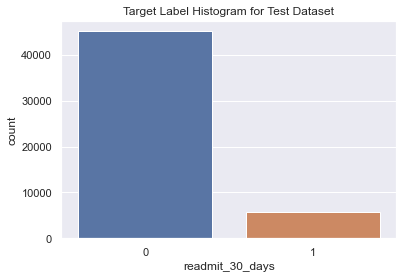

In [45]:
sns.countplot(x=Y_test)
plt.title("Target Label Histogram for Test Dataset")
outcome_test = figure_to_base64str(plt)

## Train the model

We train a logistic regression model and save its predictions on test data for analysis.

In [46]:
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

In [47]:
unmitigated_pipeline.fit(X_train_bal, Y_train_bal)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

In [48]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)

Check model performance on test data.

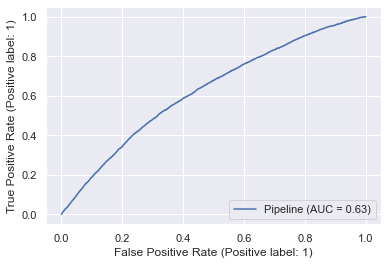

In [49]:
# Plot ROC curve of probabilistic predictions
plot_roc_curve(unmitigated_pipeline, X_test, Y_test);

In [50]:
# Show balanced accuracy rate of the 0/1 predictions
balanced_accuracy_score(Y_test, Y_pred)

0.5937900251950625

As we see, the performance of the model is well above the performance of a coin flip (whose performance would be 0.5 in both cases), albeit it is quite far from a perfect classifier (whose performance would be 1.0 in both cases).


## Inspect the coefficients of trained model

We check the coefficients of the fitted model to make sure that they "makes sense". While subjective, this step is important and helps catch mistakes and might point out to some fairness issues. However, we will systematically assess the fairness of the model in the next section.

*Note that coefficients are also a proxy for "feature importance", but this interpretation can be misleading when features are highly correlated.*

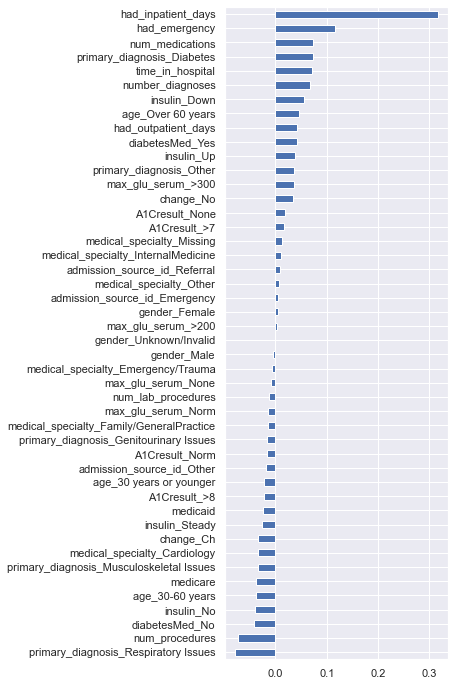

In [51]:
coef_series = pd.Series(data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0], index=X.columns)
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False);

# **Fairness assessment**

## Measuring fairness-related harms





The goal of fairness assessment is to answer the question: *Which groups of people may be disproportionately negatively impacted by an AI system and in what ways?*

The steps of the assesment are as follows:
1. Identify harms
2. Identify the groups that might be harmed
3. Quantify harms
4. Compare quantified harms across the groups

We next examine these four steps in more detail.

### 1. Identify harms

For example, in a system for screening job applications, qualified candidates that are automatically rejected experience an allocation harm. In a speech-to-text transcription system, high error rates constitute harm in the quality of service.

**In the health care scenario**, the patients that would benefit from a care management program, but are not recommended for it experience an allocation harm. In the context of the classification scenario these are **FALSE NEGATIVES**.

### 2. Identify the groups that might be harmed

In most applications, we consider demographic groups including historically marginalized groups (e.g., based on gender, race, ethnicity). We should also consider groups that are relevant to a particular application. For example, for speech-to-text transcription, groups based on the regional dialect or being a native or a non-native speaker.

It is also important to consider group intersections, for example, in addition to considering groups according to gender and groups according to race, it is also important to consider their intersections (e.g., Black women, Latinx nonbinary people, etc.).

**In the health care scenario**, based on the previous work, we focus on groups defined by **RACE**.

### 3. Quantify harms

Define metrics that quantify harms or benefits:

* In job screening scenario, we need to quantify the number of candidates that are classified as "negative" (not recommended for the job), but whose true label is "positive" (they are qualified). One possible metric is the **false negative rate**: fraction of qualified candidates that are screened out.

* In speech-to-text scenario, the harm could be measured by **word error rate**, number of mistakes in a transcript divided by the overall number of words.

* **In the health care scenario**, we could consider two metrics for quantifying harms / benefits:
  * **false negative rate**: fraction of patients that are readmitted within 30 days, but that are not recommended for the care management program; this quantifies harm
  * **selection rate**: overall fraction of patients that are recommended for the care management program (regardless of whether they are readmittted with 30 days or no); this quantifies benefit; here the assumption is that all patients benefit similarly from the extra care.

There are several reasons for including selection rate in addition to false negative rate. We would like to monitor how the benefits are allocated, focusing on groups that might be disadvantaged. Another reason is to get extra robustness in our assessement, because our measure (i.e., readmission within 30 days) is only an imperfect measure of our construct (who is most likely to benefit from the care management program). The auxiliary metrics, like selection rate, may alert us to large disparities in how the benefit is allocated, and allow us to catch issues that we might have missed.


### 4. Compare quantified harms across the groups

The workhorse of fairness assessment are _disaggregated metrics_, which are **metrics evaluated on slices of data**. For example, to measure harms due to errors, we would begin by evaluating the errors on each slice of the data that corresponds to a group we identified in Step 2.
If some of the groups are seeing much larger errors than other groups, we would flag this as a fairness harm.

To summarize the disparities in errors (or other metrics), we may want to report quantities such as the **difference** or **ratio** of the metric values between the best and the worst slice. In settings where the goal is to guarantee certain minimum quality of service (such as speech recognition), it is also meaningful to report the **worst performance** across all considered groups.



For example, when comparing false negative rate across groups defined by race, we may summarize our findings with a table like the following:

| | false negative rate<br>(FNR) |
|---|---|
| AfricanAmerican | 0.43 |
| Caucasian | 0.44 |
| Other | 0.52 |
| Unknown | 0.67 |
| | |
|_largest difference_| 0.24 &nbsp;&nbsp;(best is 0.0)|
|_smallest ratio_| 0.64 &nbsp;&nbsp;(best is 1.0)|
|_maximum_<br>_(worst-case) FNR_|0.67|

## Fairness assessment with `MetricFrame`

Fairlearn provides the data structure called `MetricFrame` to enable evaluation of disaggregated metrics. We will show how to use a `MetricFrame` object to assess the trained `LogisticRegression` classifier for potential fairness-related harms.



In [52]:
# In its simplest form MetricFrame takes four arguments:
#    metric_function with signature metric_function(y_true, y_pred)
#    y_true: array of labels
#    y_pred: array of predictions
#    sensitive_features: array of sensitive feature values

mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

mf1.by_group

race
AfricanAmerican   0.428
Caucasian         0.442
Other             0.523
Unknown           0.670
Name: false_negative_rate, dtype: object

In [53]:
# The largest difference, smallest ratio and worst-case performance are accessed as
#   mf1.difference(), mf1.ratio(), mf1.group_max()

print(f"difference: {mf1.difference():.3}\n"
      f"ratio: {mf1.ratio():.3}\n"
      f"max across groups: {mf1.group_max():.3}")

difference: 0.242
ratio: 0.639
max across groups: 0.67


In [54]:
# You can also evaluate multiple metrics by providing a dictionary

metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are then stored in a pandas DataFrame:

metricframe_unmitigated.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.400,0.428,0.597
Caucasian,0.391,0.442,0.594
Other,0.328,0.523,0.584
Unknown,0.264,0.670,0.536


In [55]:
# The largest difference, smallest ratio, and the maximum and minimum values
# across the groups are then all pandas Series, for example:

metricframe_unmitigated.difference()

selection_rate        0.137
false_negative_rate   0.242
balanced_accuracy     0.061
dtype: object

In [56]:
# You'll probably want to view them transposed:

pd.DataFrame({'difference': metricframe_unmitigated.difference(),
              'ratio': metricframe_unmitigated.ratio(),
              'group_min': metricframe_unmitigated.group_min(),
              'group_max': metricframe_unmitigated.group_max()}).T

,selection_rate,false_negative_rate,balanced_accuracy
difference,0.137,0.242,0.061
ratio,0.659,0.639,0.897
group_min,0.264,0.428,0.536
group_max,0.400,0.670,0.597


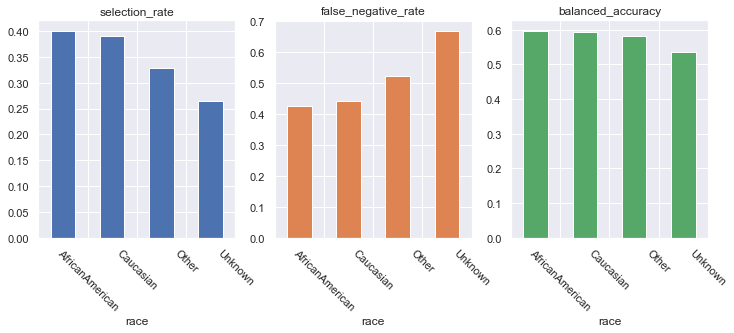

In [57]:
# You can also easily plot all of the metrics using DataFrame plotting capabilities

metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [1,3], figsize=(12, 4),
                      legend=False, rot=-45, position=1.5);

According to the above bar chart, it seems that the group *Unknown* is selected for the care management program less often than other groups as reflected by the selection rate. Also this group experiences the largest false negative rate, so a larger fraction of group members that are likely to benefit from the care management program are not selected. Finally, the balanced accuracy on this group is also the lowest.



We observe disparity, even though we did not include race in our model. There's a variety of reasons why such disparities may occur. It could be due to representational issues (i.e., not enough instances per group), or because the feature distribution itself differs across groups (i.e., different relationship between features and target variable, obvious example would be people with darker skin in facial recognition systems, but can be much more subtle). Real-world applications often exhibit both kinds of issues at the same time.

<a name="train-other-models"></a>
## Exercise: Train other fairness-unaware models

In this section, you'll be training your own fairness-unaware model and evaluate the model using the `MetricFrame` for fairness-related harms.

We encourage you to explore the model's performance across different sensitive features (such as `age` or `gender`) as well as different model performance metrics.

1.) First, let's train our machine learning model. We'll create a `HistGradientBoostingClassifier` and fit it to the balanced training data set.

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Create your model here
clf = HistGradientBoostingClassifier()

# Fit the model to the training data
clf.fit(__________, ________)
exercise_pred = clf.predict(______)

2.) Next, let's evaluate the fairness of the model using the `MetricFrame`. In the below cells, create a `MetricFrame` that looks at the following metrics:


*   _Count_: The number of data points belonging to each sensitive feature category.
*   _False Positive Rate_: $\dfrac{FP}{FP+TN}$
*  _Recall Score_: $\dfrac{TP}{TP+FN}$

As an extra challenge, you can use the prediction probabilities to compute the _ROC AUC Score_ for each sensitive group pair.



In [ ]:
# Define exercise fairness metrics of interest here
exercise_metrics = {
    "count": count,
    "false_positive_rate": _______,
    "recall_score": _______
}

Now, let's create our `MetricFrame` using the metrics listed above with the sensitive groups of `race` and `gender`.

In [ ]:
metricframe_exercise = MetricFrame(
    metrics=__________,
    y_true=Y_test,
    y_pred=__________,
    sensitive_features=_____
)

3.) Finally, play around with the plotting capabilities of the `MetricFrame` in the below section.



In [ ]:
metricframe_exercise._______

In [ ]:
# Plot some of the performance disparities here
metricframe_exercise.by_group.____.bar(subplots=_____, layout=[1,3], figsize=(12, 4),
                                       legend=False, rot=-45, position=1.5)

The charts above are based on test data, so without any uncertainty quantification (such as error bars or confidence intervals), we cannot reliably compare these data statistics. Next optional section shows how to augment MetricFrame with the report of error bars.

## Adding error bars [OPTIONAL SECTION]

In this section, we define new custom metrics that quantify errors in our estimates of selection rate, false negative rate and balanced accuracy, and then review our metrics again.

In [ ]:
# All of our error bar calculations are based on normal approximation to
# the binomial variables.

def error_bar_normal(n_successes, n_trials, z=1.96):
  """
  Computes the error bars for the parameter p of a binomial variable
  using normal approximation. The default value z corresponds to the 95%
  confidence interval.
  """
  point_est = n_successes / n_trials
  error_bar = z*np.sqrt(point_est*(1-point_est))/np.sqrt(n_trials)
  return error_bar

def fpr_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the false positive rate
  """
  tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()
  return error_bar_normal(fp, tn+fp)

def fnr_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the false negative rate
  """
  tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()
  return error_bar_normal(fn, fn+tp)

def selection_rate_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the selection rate
  """
  tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()
  return error_bar_normal(tp+fp, tn+fp+fn+tp)

def balanced_accuracy_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the balanced accuracy
  """
  fnr_err, fpr_err = fnr_error(Y_true, Y_pred), fpr_error(Y_true, Y_pred)
  return np.sqrt(fnr_err**2 + fpr_err**2)/2

We next create a metric frame that includes the sample sizes and error bar sizes in addition to the metrics that we have used previously.

In [ ]:
metrics_with_err_bars = {
    "count": count,
    "selection_rate": selection_rate,
    "selection_err_bar": selection_rate_error,
    "false_negative_rate": false_negative_rate,
    "fnr_err_bar": fnr_error,
    "balanced_accuracy": balanced_accuracy_score,
    "bal_acc_err_bar": balanced_accuracy_error
}

# sometimes we will only want to display metrics without error bars
metrics_to_display = [
    "count",
    "selection_rate",
    "false_negative_rate",
    "balanced_accuracy"
]

# sometimes we will only want to show the difference values of the metrics other than count
differences_to_display = [
    "selection_rate",
    "false_negative_rate",
    "balanced_accuracy"
]

In [ ]:
metricframe_unmitigated_w_err = MetricFrame(
    metrics=metrics_with_err_bars,
    y_true=Y_test,
    y_pred=Y_pred,
    sensitive_features=A_test
)

In [ ]:
unmitigated_groups = metricframe_unmitigated_w_err.by_group
unmitigated_groups # show both the metrics as well as the error bars

We see that for smaller sample sizes we have larger error bars. The problem is further exacerbated for false negative rate, which is estimated only over *positive examples* and so its sample sizes is further reduced due to label imbalance.

We next visualize the metrics with the corresponding error bars using a custom plotting function.

In [ ]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
  """
  Plots the disaggregated `metric` for each group with an associated
  error bar. Both metric and the erro bar are provided as columns in the 
  provided metricframe.
  """
  grouped_metrics = metricframe.by_group
  point_estimates = grouped_metrics[metric]
  error_bars = grouped_metrics[error_name]
  lower_bounds = point_estimates - error_bars
  upper_bounds = point_estimates + error_bars

  x_axis_names = [str(name) for name in error_bars.index.to_flat_index().tolist()]
  plt.vlines(x_axis_names, lower_bounds, upper_bounds, linestyles="dashed", alpha=0.45)
  plt.scatter(x_axis_names, point_estimates, s=25)
  plt.xticks(rotation=0)
  y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(max(upper_bounds), decimals=2)
  plt.yticks(np.arange(y_start, y_end, 0.05))
  plt.ylabel(metric)

In [ ]:
plot_group_metrics_with_error_bars(metricframe_unmitigated_w_err, "selection_rate", "selection_err_bar")

In [ ]:
plot_group_metrics_with_error_bars(metricframe_unmitigated_w_err, "false_negative_rate", "fnr_err_bar")

In [ ]:
plot_group_metrics_with_error_bars(metricframe_unmitigated_w_err, "balanced_accuracy", "bal_acc_err_bar")

As we see above, even accounting for the larger uncertainty in estimating the false negative rate for *Unknown*, this group is experiencing substantially larger false negative rate than other groups and thus experiences the harm of allocation.



---


# **Mitigating fairness-related harms in ML models**

We have found that the logistic regression predictor leads to a large difference in false negative rates between the groups. We next look at **algorithmic mitigation strategies** of this fairness issue (and similar ones).

*Note that while we currently focus on the training stage of the AI lifecycle mitigation should not be limited to this stage. In fact, we have already discussed mitigation strategies that are applicable at the task definition stage (e.g., checking for construct validity) and data collection stage (e.g., collecting more data).*

Within the model training stage, mitigation may occur at different steps relative to model training:

* **Preprocessing**: A mitigation algorithm is applied to transform the input data to the training algorithm; for example, some strategies seek to remove and dependence between the input features and sensitive features.

* **At training time**: The model is trained by an (optimization) algorithm that seeks to satisfy fairness constraints.

* **Postprocessing**: The output of a trained model is transformed to mitigate fairness issues; for example, the predicted probability of readmission is thresholded according to a group-specific threshold.

We will now dive into two algorithms: a postprocessing approach and a reductions approach (which is a training-time algorithm). Both of them are in fact **meta-algorithms** in the sense that they act as wrappers around *any* standard (fairness-unaware) machine learning algorithms. This makes them quite versatile in practice.


## Postprocessing with `ThresholdOptimizer`

**Postprocessing** techniques are a class of unfairness-mitigation algorithms that take an already trained model and a dataset as an input and seek to fit a transformation function to model's outputs to satisfy some (group) fairness constraint(s). They might be the only feasible unfairness mitigation approach when developers cannot influence training of the model, due to practical reasons or due to security or privacy.


Here we use the `ThresholdOptimizer` algorithm from Fairlearn, which follows the approach of [Hardt, Price, and Srebro (2016)](https://arxiv.org/abs/1610.02413).

`ThresholdOptimizer` takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate thrceshold for each group in order to optimize some specified objective metric (such as **balanced accuracy**) subject to specified fairness constraints (such as **false negative rate parity**). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

The constraint **false negative rate parity** requires that all the groups have equal values of false negative rate.



To instatiate our `ThresholdOptimizer`, we pass in:

*   An existing `estimator` that we wish to threshold. 
*   The fairness `constraints` we want to satisfy.
*   The `objective` metric we want to maximize.



In [58]:
# Now we instantite ThresholdOptimizer with the logistic regression estimator
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In order to use the `ThresholdOptimizer`, we need access to the sensitive features **both during training time and once it's deployed**.

In [59]:
postprocess_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

c:\users\v-manandi\anaconda3\envs\scipy_tutorial\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:309: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
  type(self).__name__
c:\users\v-manandi\anaconda3\envs\scipy_tutorial\lib\site-packages\fairlearn\postprocessing\_interpolated_thresholder.py:115: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could m

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=Pipeline(steps=[('preprocessing',
                                              StandardScaler()),
                                             ('logistic_regression',
                                              LogisticRegression(max_iter=1000))]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [60]:
# Record and evaluate the output of the trained ThresholdOptimizer on test data

Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=A_test
)

We can now inspect how the metric values differ between the postprocessed model and the unmitigated model:

In [61]:
pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1)

Unmitigated                                        \
                selection_rate false_negative_rate balanced_accuracy   
race                                                                   
AfricanAmerican          0.400               0.428             0.597   
Caucasian                0.391               0.442             0.594   
Other                    0.328               0.523             0.584   
Unknown                  0.264               0.670             0.536   

                ThresholdOptimizer                                        
                    selection_rate false_negative_rate balanced_accuracy  
race                                                                      
AfricanAmerican              0.427               0.400             0.598  
Caucasian                    0.451               0.389             0.590  
Other                        0.412               0.455             0.574  
Unknown                      0.459               0.436             0.557

We next zoom in on differences between the largest and the smallest metric values:

In [62]:
pd.concat([metricframe_unmitigated.difference(),
           metricframe_postprocess.difference()],
          keys=['Unmitigated: difference', 'ThresholdOptimizer: difference'],
          axis=1).T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated: difference,0.137,0.242,0.061
ThresholdOptimizer: difference,0.047,0.066,0.041


As we see, `ThresholdOptimizer` was able to substantiallydecrease the difference between the values of false negative rate.

Finally, we save the disagregated statistics:

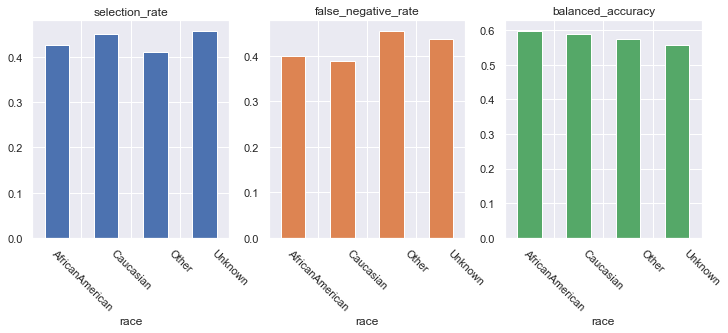

In [63]:
metricframe_postprocess.by_group.plot.bar(subplots=True, layout=[1,3], figsize=(12, 4), legend=False, rot=-45, position=1.5)
postprocess_performance = figure_to_base64str(plt)

Next optional section shows that `ThresholdOptimizer` more closely satisfies constraints on the training data than on the test data.

### Postprocessing: Correctness check [OPTIONAL SECTION]

We can verify that `ThresholdOptimizer` achieves false negative rate parity on the training dataset, meaning that the values of the false negative rate parity with respect to all groups are close on the training data.

In [64]:
# Record and evaluate the output of the ThresholdOptimizer on the training data

Y_pred_postprocess_training = postprocess_est.predict(X_train_bal, sensitive_features=A_train_bal)
metricframe_postprocess_training = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_train_bal,
    y_pred=Y_pred_postprocess_training,
    sensitive_features=A_train_bal
)
metricframe_postprocess_training.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.505,0.372,0.616
Caucasian,0.525,0.379,0.599
Other,0.491,0.385,0.612
Unknown,0.486,0.383,0.613


In [65]:
# Evaluate the difference between the largest and smallest value of each metric
metricframe_postprocess_training.difference()

selection_rate        0.038
false_negative_rate   0.013
balanced_accuracy     0.018
dtype: object

The value of `false_negative_rate_difference` on the training data is smaller than on the test data.

<a name="exercise-threshold"></a>
### Exercise: ThresholdOptimizer

In this exercise, we will create a `ThresholdOptimizer` by constraining the *true positive rate* (also known as the *recall score*). For any model, the *true positive rate* + *false negative rate* = 1. 

By trying to achieve the *true positive rate parity*, we should produce a `ThresholdOptimizer` with the same performance as our original `ThresholdOptimizer`.



#### 1.) Create a new ThresholdOptimizer with the constraint `true_positive_rate_parity` and objective `balanced_accuracy_score`.

In [66]:
thresopt_exercise = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="true_positive_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In [67]:
thresopt_exercise.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)
threshopt_pred = thresopt_exercise.predict(X_test, sensitive_features=A_test)

c:\users\v-manandi\anaconda3\envs\scipy_tutorial\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:309: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
  type(self).__name__
c:\users\v-manandi\anaconda3\envs\scipy_tutorial\lib\site-packages\fairlearn\postprocessing\_interpolated_thresholder.py:115: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could m

#### 2.) Create a new `MetricFrame` object to process the results of this classifier.

In [68]:
thresop_metricframe = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=threshopt_pred,
    sensitive_features=A_test
)

#### 3.) Compare the performance of the two `ThresholdOptimizers`.

In [69]:
# Visualize the performance of the new ThresholdOptimizer
thresop_metricframe.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.427,0.400,0.598
Caucasian,0.450,0.389,0.590
Other,0.412,0.446,0.580
Unknown,0.469,0.404,0.569


In [70]:
# Compare the performance to the original ThresholdOptimizer
metricframe_postprocess.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.427,0.400,0.598
Caucasian,0.451,0.389,0.590
Other,0.412,0.455,0.574
Unknown,0.459,0.436,0.557


Similar to many unfairness mitigation approaches, `ThresholdOptimizer` produces randomized classifiers. Next optional section presents a heuristic strategy for converting a randomized `ThresholdOptimizer` into a deterministic one. In our scenario, this heursitic is quite effective and the resulting deterministic classifier has similar performance as the original `ThresholdOptimizer`.

### Deployment considerations: Randomized predictions [OPTIONAL SECTION]

When we were describing `ThresholdOptimizer` we said that it picks a separate threshold for each group. However, that is not quite correct. In fact,`ThresholdOptimizer`, for each group, picks two thresholds that are close to each other (say `threshold0` and `threshold1`) and then, at deployment time, randomizes between the two: choosing `threshold0` with some probability `p0` and `threshold1` with the remaining probability `p1=1-p0` (the specific probabilities are determined during training; for certain kinds of constraints, three thresholds are considered.)

This means that the predictions are randomized. To achieve reproducible randomization, it is possible to provide an argument `random_state` to the `predict` method. However, in some settings, even such reproducible randomization is not acceptable and can be in fact viewed as a fairness issue, because of its arbitrariness.

One derandomization heuristic is to replace the two thresholds by their weighted average, i.e., `threshold = p0*threshold0 + p1*threshold1`. That corresponds to the assumption that the values of the scores between the two thresholds are approximately uniformly distributed. Using this heuristic, we derandomize `ThresholdOptimizer`.



The randomized model of the `ThresholdOptimizer` is stored as the field
`interpolated_thresholder_` in the fitted ThresholdOptimizer, which is itself a
valid estimator of type `InterpolatedThresholder`:

In [71]:
interpolated = postprocess_est.interpolated_thresholder_
interpolated

InterpolatedThresholder(estimator=Pipeline(steps=[('preprocessing',
                                                   StandardScaler()),
                                                  ('logistic_regression',
                                                   LogisticRegression(max_iter=1000))]),
                        interpolation_dict={'AfricanAmerican': {'operation0': [>0.4807478640752806],
                                                                'operation1': [>0.529649951710353],
                                                                'p0': 0.8307815126050422,
                                                                'p1': 0.16921848739495782},
                                            'Caucasian': {'operation0': [>0.47659266634712427...
                                                          'p0': 0.6009999999998796,
                                                          'p1': 0.39900000000012037},
                                            'Other': {'operation0': [>0.45349385499174055],
                                                      'operation1': [>0.49548258291649594],
                                                      'p0': 0.6000000000000001,
                                                      'p1': 0.3999999999999999},
                                            'Unknown': {'operation0': [>0.42796506996906125],
                                                        'operation1': [>0.4498310411887575],
                                                        'p0': 0.7612727272727273,
                                                        'p1': 0.23872727272727268}},
                        predict_method='predict_proba', prefit=True)

The `interpolation_dict` is a dictionary which assign to each sensitive feature value two thresholds and two respective probabilities. Using our derandomization strategy, we can create a dictionary that represents a deterministic rule:


In [72]:
def create_deterministic(interpolate_dict):
  """
  Creates a deterministic interpolation_dictionary from a randomized
  interpolation_dictionary. The determinstic thresholds are created by taking
  the weighted combinations of the two randomized thresholds for each sensitive
  group.
  """
  deterministic_dict = {}
  for (race, operations) in interpolate_dict.items():
    op0, op1 = operations["operation0"]._threshold, operations["operation1"]._threshold
    p0, p1 = operations["p0"], operations["p1"]
    deterministic_dict[race] = Bunch(
      p0=0.0,
      p1=1.0,
      operation0=ThresholdOperation(operator=">",threshold=(p0*op0 + p1*op1)),
      operation1=ThresholdOperation(operator=">",threshold=(p0*op0 + p1*op1))
    )
  return deterministic_dict

In [73]:
deterministic_dict = create_deterministic(interpolated.interpolation_dict)
deterministic_dict

{'AfricanAmerican': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.4890230013753432],
  'operation1': [>0.4890230013753432]},
 'Caucasian': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.47664354593739394],
  'operation1': [>0.47664354593739394]},
 'Other': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.47028934616164275],
  'operation1': [>0.47028934616164275]},
 'Unknown': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.4331850736438724],
  'operation1': [>0.4331850736438724]}}

Now, we can create an `InterpolatedThresholder` that uses the same pre-fit estimator, but with derandomized thresholds.

In [74]:
deterministic_thresholder = InterpolatedThresholder(estimator=interpolated.estimator,
                                                 interpolation_dict=deterministic_dict,
                                                 prefit=True,
                                                 predict_method='predict_proba')

In [75]:
deterministic_thresholder.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

c:\users\v-manandi\anaconda3\envs\scipy_tutorial\lib\site-packages\fairlearn\postprocessing\_interpolated_thresholder.py:115: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing InterpolatedThresholder with `prefit=True`. In case (2), please use `prefit=False`.
  warn(BASE_ESTIMATOR_NOT_FITTED_WARNING.format(type(self).__name__))


InterpolatedThresholder(estimator=Pipeline(steps=[('preprocessing',
                                                   StandardScaler()),
                                                  ('logistic_regression',
                                                   LogisticRegression(max_iter=1000))]),
                        interpolation_dict={'AfricanAmerican': {'operation0': [>0.4890230013753432],
                                                                'operation1': [>0.4890230013753432],
                                                                'p0': 0.0,
                                                                'p1': 1.0},
                                            'Caucasian': {'operation0': [>0.47664354593739394],
                                                          'operation1': [>0.47664354593739394],
                                                          'p0': 0.0,
                                                          'p1': 1.0},
                                            'Other': {'operation0': [>0.47028934616164275],
                                                      'operation1': [>0.47028934616164275],
                                                      'p0': 0.0, 'p1': 1.0},
                                            'Unknown': {'operation0': [>0.4331850736438724],
                                                        'operation1': [>0.4331850736438724],
                                                        'p0': 0.0, 'p1': 1.0}},
                        predict_method='predict_proba', prefit=True)

In [76]:
y_pred_postprocess_deterministic = deterministic_thresholder.predict(X_test, sensitive_features=A_test)

In [77]:
mf_deterministic = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=y_pred_postprocess_deterministic,
    sensitive_features=A_test
)

Now compare the two models in terms of their disaggregated metrics:

In [78]:
mf_deterministic.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.424,0.405,0.597
Caucasian,0.451,0.389,0.590
Other,0.405,0.437,0.588
Unknown,0.466,0.404,0.571


In [79]:
metricframe_postprocess.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.427,0.400,0.598
Caucasian,0.451,0.389,0.590
Other,0.412,0.455,0.574
Unknown,0.459,0.436,0.557


The differences are generally small except for the *Unknown* group, whose false negative rate goes down and balanced accuracy goes up.

## Reductions approach with `ExponentiatedGradient`

With the `ThresholdOptimizer`, we took a fairness-unaware model and transformed the model's decision boundary to satisfy our fairness constraints. One limitation of `ThresholdOptimizer` is that it needs access to the sensitive features at deployment time.

In this section, we will show how to use the _reductions_ approach of [Agarwal et. al (2018)](https://arxiv.org/abs/1803.02453) to obtain a model that satisfies the fairness constraints, but does not need access to sensitive features at deployment time.

Terminology "reductions" refers to another kind of a wrapper approach, which instead of wrapping an already trained model, wraps any standard classification or regression algorithm, such as 
`LogisticRegression`. In other words, an input to a reduction algorithm is an object that supports training on any provided (weighted) dataset. In addition, a reduction algorithm receives a data set that includes sensitive features. The goal, like with post-processing, is to optimize a performance metric (such as classification accuracy) subject to fairness constraints (such as an upper bound on differences between false negative rates).

The main reduction algorithm algorithm in Fairlearn is `ExponentiatedGradient`. It creates a sequence of reweighted datasets and retrains the wrapped model on each of them. The 
retraining process is guaranteed to find a model that satisfies the fairness constraints while optimizing the performance metric.

The model returned by `ExponentiatedGradient` consists of several inner models, returned by the wrapped estimator. At deployment time, `ExponentiatedGradient` randomizes among these models according to a specific probability weights.

To instantiate an `ExponentiatedGradient` model, we pass in two parameters:

*   A base `estimator` (an object that supports training)
*   Fairness `constraints` (an object of type `Moment`).

The constraints supported by `ExponentiatedGradient` are more general than those supported by `ThresholdOptimizer`. For example, rather than requiring that false negative rates be equal, it is possible to specify the maxium allowed difference or ratio between the largest and the smallest value.


In [80]:
expgrad_est = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000, random_state=random_seed),
    constraints=TruePositiveRateParity(difference_bound=0.02)
)

The constraints above are expressed for the true positive parity, they require that the difference between the largest and the smallest true positive rate (TPR) across all groups be at most 0.02. Since false negative rate (FNR) is equal to 1-TPR, this is equivalent to requiring that the difference between the largest and smallest FNR be at most 0.02.

In [81]:
# Fit the exponentiated gradient model
expgrad_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

c:\users\v-manandi\anaconda3\envs\scipy_tutorial\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
c:\users\v-manandi\anaconda3\envs\scipy_tutorial\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
c:\users\v-manandi\anaconda3\envs\scipy_tutorial\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame 

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x00000268272DA488>,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=445),
                      nu=0.002303268819590091)

Similarly to `ThresholdOptimizer` the predictions of `ExponentiatedGradient` models are randomized. If we want to assure reproducible results, we can pass  `random_state` to the `predict` function. 

In [82]:
# Record and evaluate predictions on test data

Y_pred_reductions = expgrad_est.predict(X_test, random_state=random_seed)
metricframe_reductions = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_reductions,
    sensitive_features=A_test
)
metricframe_reductions.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.408,0.424,0.595
Caucasian,0.398,0.445,0.588
Other,0.338,0.518,0.580
Unknown,0.344,0.574,0.545


In [83]:
# Evaluate the difference between the largest and smallest value of each metric
metricframe_reductions.difference()

selection_rate        0.070
false_negative_rate   0.150
balanced_accuracy     0.050
dtype: object

While there is a decrease in the false negative rate difference from the unmitigated model, this decrease is not as substantial as with `ThresholdOptimizer`. Note, however, that `ThresholdOptimizer` was able to use the sensitive feature (i.e., race) at deployment time.

### Explore individual predictors

During the training process, the `ExponentiatedGradient` algorithm iteratively trains multiple inner models on a reweighted training dataset. The algorithm stores each of these predictors and then randomizes among them at deployment time.

In many applications, the randomization is undesirable, and also using multiple inner models can pose issues for interpretability. However, the inner models that `ExponentiatedGradient` relies on span a variety of fairness-accuracy trade-offs, and they could be considered for stand-alone deployment: addressing the randomization and interpretability issues, while possibly offering additional flexibility thanks to a variety of trade-offs. 

In this section explore the performance of the individual predictors learned by the `ExponentiatedGradient` algorithm. First, note that since the base estimator was `LogisticRegression` all these predictors are different logistic regression models:

In [84]:
predictors = expgrad_est.predictors_
predictors

0    LogisticRegression(max_iter=1000, random_state...
1    LogisticRegression(max_iter=1000, random_state...
2    LogisticRegression(max_iter=1000, random_state...
3    LogisticRegression(max_iter=1000, random_state...
4    LogisticRegression(max_iter=1000, random_state...
5    LogisticRegression(max_iter=1000, random_state...
6    LogisticRegression(max_iter=1000, random_state...
7    LogisticRegression(max_iter=1000, random_state...
8    LogisticRegression(max_iter=1000, random_state...
dtype: object

In [85]:
# Collect predictions by all predictors and calculate balanced error
# as well as the false negative difference for all of them

sweep_preds = [clf.predict(X_test) for clf in predictors]
balanced_error_sweep = [1-balanced_accuracy_score(Y_test, Y_sweep) for Y_sweep in sweep_preds]
fnr_diff_sweep = [false_negative_rate_difference(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in sweep_preds]

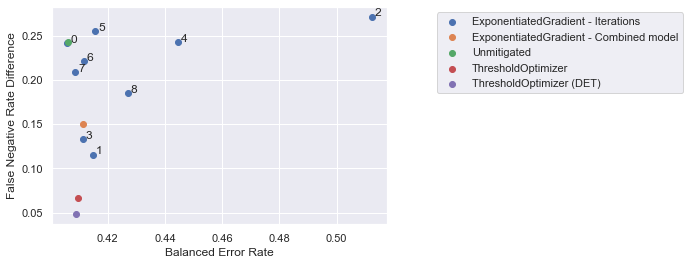

In [86]:
# Show the balanced error / fnr difference values of all predictors on a raster plot  

plt.scatter(balanced_error_sweep, fnr_diff_sweep, label="ExponentiatedGradient - Iterations")
for i in range(len(predictors)):
  plt.annotate(str(i), xy=(balanced_error_sweep[i]+0.001, fnr_diff_sweep[i]+0.001))

# Also include in the plot the combined ExponentiatedGradient model
# as well as the three previously fitted models

plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_reductions),
            false_negative_rate_difference(Y_test, Y_pred_reductions, sensitive_features=A_test),
            label="ExponentiatedGradient - Combined model")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred),
            false_negative_rate_difference(Y_test, Y_pred, sensitive_features=A_test),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_postprocess),
            false_negative_rate_difference(Y_test, Y_pred_postprocess, sensitive_features=A_test),
            label="ThresholdOptimizer")
plt.scatter(1-balanced_accuracy_score(Y_test, y_pred_postprocess_deterministic),
            false_negative_rate_difference(Y_test, y_pred_postprocess_deterministic, sensitive_features=A_test),
            label="ThresholdOptimizer (DET)")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

<a name="exercise-reductions"></a>
### Exercise: Train an `ExponentiatedGradient` model

In this section, we will explore how changing the base model for the `ExponentiatedGradient` affects the overall performance of the classifier. 

We will instatiate a new `ExponentiatedGradient` classifier with a base `HistGradientBoostingClassifer` estimator. We will use the same `difference_bound` as above.

1.) First, let's create our new `ExponentiatedGradient` instance in the cells below and fit it to the training data.

In [ ]:
# Create ExponentiatedGradient instance here
expgrad_exercise = ExponentiatedGradient(
    estimator=_______,
    constraints=TruePositiveRateParity(difference_bound=____)
)

In [ ]:
# Fit the new instance to the balanced training dataset
expgrad_exercise.fit(________, _________, sensitive_features=________)

2.) Now, let's compute the performance of the `ExponentiatedGradient` model and compare it with the performance of `ExponentiatedGradient` model with logistic regression as base estimator

In [ ]:
# Save the predictions and report the disagregated metrics
# of the exponantiated gradient model
Y_expgrad_exercise = expgrad_exercise.predict(X_test)
mf_expgrad_exercise = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=_______,
    sensitive_features=________
)
mf_expgrad_exercise.______

In [ ]:
# Compare with the disaggregated metric values of the
# exponentiated gradient model based on logistic regression
metricframe_reductions.____

3.) Next, calculate the balanced error rate and false negative rate difference of each of the inner models learned by this new `ExponentiatedGradient` classifier.

In [ ]:
# Save the inner predictors of the new model
predictors_exercise = expgrad_exercise.predictors_

In [ ]:
# Compute the balanced error rate and false negative rate difference for each of the predictors on the test data.
balanced_error_exercise = [(1 - ______(Y_test, pred.predict(X_test))) for pred in predictors_exercise]
false_neg_exercise = [(______(Y_test, pred.predict(X_test), sensitive_features=_____)) for pred in predictors_exercise]

4.) Finally, let's plot the performances of these individual inner models. In the below cells, plot the individual inner predictors against the performance of their corresponding exponentiated gradient model as well as the unmitigated logistic regression model, and the `ThresholdOptimizer`.

In [ ]:
# Plot the individual predictors against the Unmitigated Model and the ThresholdOptimizer
plt.scatter(balanced_error_exercise, false_neg_exercise,
            label="ExponentiatedGradient - Iterations - Exercise")
for i in range(len(predictors_exercise)):
  plt.annotate(str(i), xy=(balanced_error_exercise[i]+0.001, false_neg_exercise[i]+0.001))

plt.scatter(1-balanced_accuracy_score(Y_test, Y_expgrad_exercise),
            false_negative_rate_difference(Y_test, Y_expgrad_exercise, sensitive_features=A_test),
            label="ExponentiatedGradient - Combined - Exercise")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred),
            false_negative_rate_difference(Y_test, Y_pred, sensitive_features=A_test),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_postprocess),
            false_negative_rate_difference(Y_test, Y_pred_postprocess, sensitive_features=A_test),
            label="ThresholdOptimizer")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

## Comparing performance of different techniques

Now we have covered two different class of techniques for mitigating the fairness-related harms we found in our fairness-unaware model. In this section, we will compare the performance of the models we trained above across our key metrics.

#### Model performance - by group

In [89]:
def plot_technique_comparison(mf_dict, metric):
  """
  Plots a specified metric for a given dictionary of MetricFrames.
  """
  mf_dict = {k:v.by_group[metric] for (k,v) in mf_dict.items()}
  comparison_df = pd.DataFrame.from_dict(mf_dict)
  comparison_df.plot.bar(figsize=(12, 6), legend=False)
  plt.title(metric)
  plt.xticks(rotation=0, ha='center');
  plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')

In [88]:
test_dict = {
    "Reductions": metricframe_reductions,
    "Unmitigated": metricframe_unmitigated,
    "Postprocessing": metricframe_postprocess,
    "Postprocessing (DET)": mf_deterministic
}

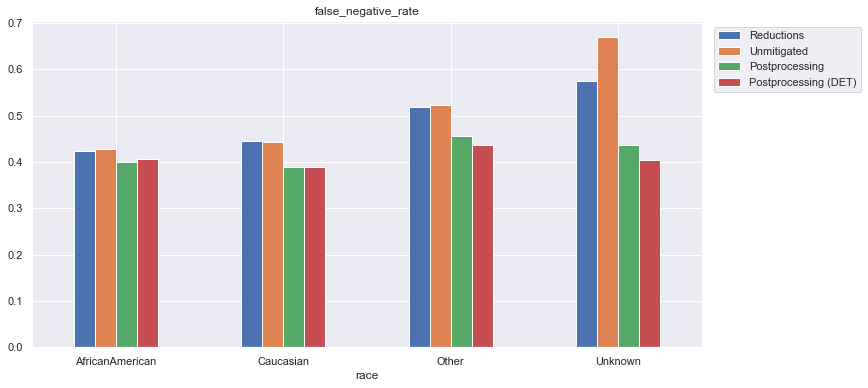

In [90]:
plot_technique_comparison(test_dict, "false_negative_rate")

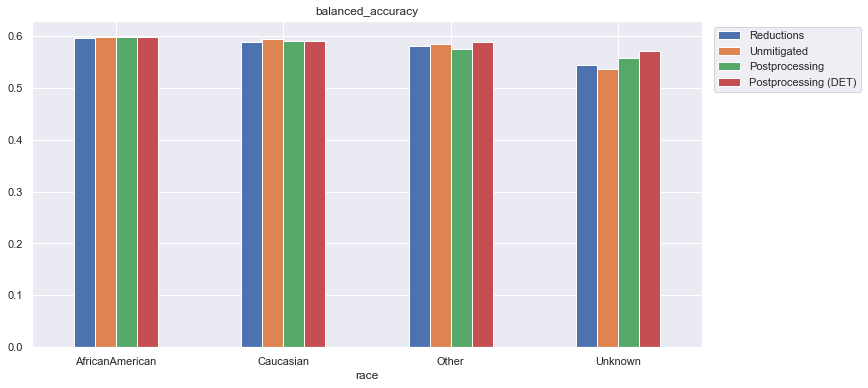

In [91]:
plot_technique_comparison(test_dict, "balanced_accuracy")

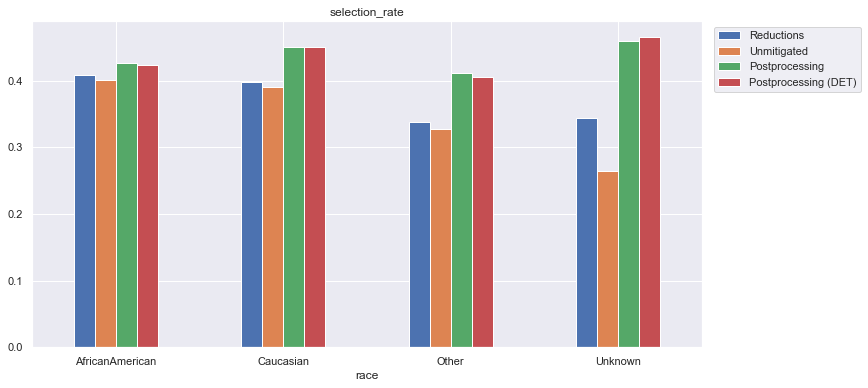

In [92]:
plot_technique_comparison(test_dict, "selection_rate")



#### Model performance - overall

In [93]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall,
    "Postprocessing (DET)": mf_deterministic.overall,
    "Reductions": metricframe_reductions.overall
})

In [94]:
overall_df.T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated,0.387,0.446,0.594
Postprocessing,0.445,0.395,0.591
Postprocessing (DET),0.444,0.394,0.591
Reductions,0.396,0.446,0.589


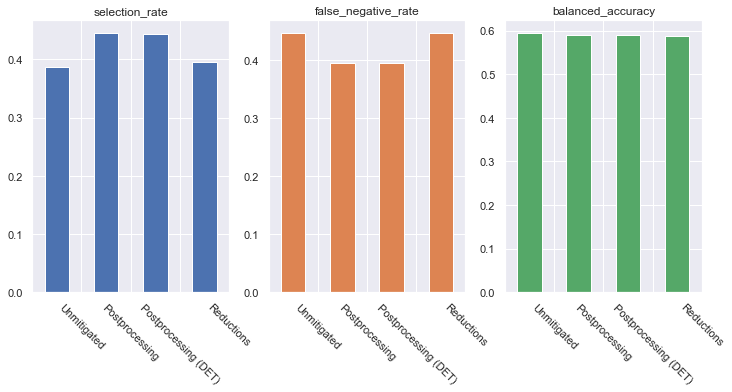

In [95]:
overall_df.transpose().plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);

In [96]:
difference_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.difference(),
    "Postprocessing": metricframe_postprocess.difference(),
    "Postprocessing (DET)": mf_deterministic.difference(),
    "Reductions": metricframe_reductions.difference()
}
)

In [97]:
difference_df.T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated,0.137,0.242,0.061
Postprocessing,0.047,0.066,0.041
Postprocessing (DET),0.061,0.048,0.026
Reductions,0.070,0.150,0.050


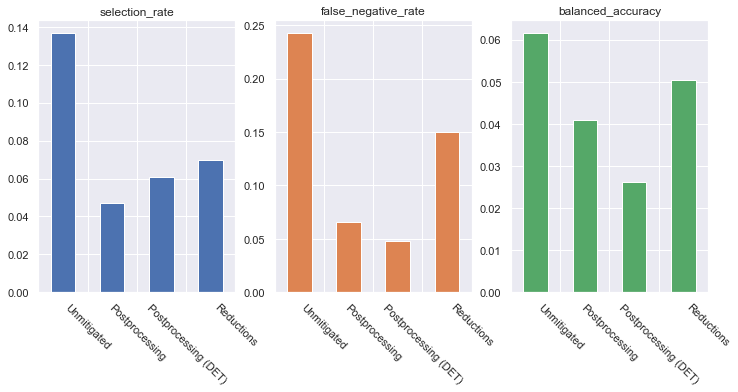

In [98]:
difference_df.T.plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);

### Randomized predictions

Both the `ExponentiatedGradient` and the `ThresholdOptimizer` yield randomized predictions (may return different result given the same instance). Due to legal regulations or other concerns, a practitioner may not be able to deploy a randomized model. To address these restrictions:

*   We created a deterministic predictor based on the randomized thresholds learned by the `ThresholdOptimizer`. This deteministic predictor achieved similar performance as the `ThresholdOptimizer`.
*   For the `ExponentiatedGradient` model, we can deploy one of the deterministic inner models rather than the overall `ExponentiatedGradient` model.



### Access to sensitive features





*   The `ThresholdOptimizer` model requires access to the sensitive features during BOTH training time and once deployed. If you do not have access to the sensitive features once the model is deployed, you will not be able to use the `ThresholdOptimizer`.
*   The `ExponentiatedGradient` model requires access to the sensitive features ONLY during training time. 




# Model cards for model reporting

_Note: The Python code in this section works in Google Colab, but it does not work on all local environments that we tested._

[Mitchell et al. (2019)](https://arxiv.org/abs/1810.03993) proposed the *model cards* framework for documenting and reporting model training details and deployment considerations. A _model card_ documents, for example, training and evaluation dataset summaries, ethical considerations, and quantitative performance results.



### Fill out the model card [OPTIONAL SECTION]

In this section, we will create a model card for one of the models we trained.

In [99]:
mct = ModelCardToolkit()
model_card = mct.scaffold_assets()


The first section of the Model Card is the _model details_ section. In _model details_, we fill in some basic information for our model.


*   _Name_: A name for the model
*   _Overview_: A brief description of the model and its intended use case
*   _Owners_: Name of individual(s) or group who created the model.
*   _References_: Any external links or references



In [100]:
model_card.model_details.name = "Diabetes Re-Admission Risk model"
model_card.model_details.overview = "This model predicts whether a patient will be re-admitted into a hospital within 30 days."
model_card.model_details.owners = [{
    "name": "Fairlearn Team",
    "contact": "https://fairlearn.org/"
}]
model_card.model_details.reference = [
    "https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008"
]
model_card.model_details.version.name = "v1.0"
model_card.model_details.version.date = str(date.today())
model_card.model_details.license = "MIT License"


In [101]:
model_card.considerations.use_cases = ["High-Risk Patient Care Management"]
model_card.considerations.users = ["Medical Professionals",  "ML Researchers"]
model_card.considerations.limitations = [
    """
    This model will not generalize to hospitals outside of the United States. Features, such as those encoding insurance
    information, are inherently tied to the U.S healthcare system.
    In addition, this model is intended for patients who are admitted into U.S. hospitals for diabetes-related illnessess.
    """
]
model_card.considerations.ethical_considerations = [{
    "name": ("Low sample sizes of certain racial groups could lead to poorer performance on these groups"),
    "mitigation_strategy": "Collect additional data points from more hospitals."
}]

The next two sections of the model card are meant to provide the reader with information about the data used to train and evaluate the model. For each of these sections, we provide a brief `description` of the data and then submit a `visualization` of the distribution of labels in the dataset.

In [102]:
model_card.model_parameters.data.train.graphics.description = (
    f"{X_train_bal.shape[0]} rows with {X_train_bal.shape[1]} features. "
    f"The original training data set was undersampled to allow for an equal number of positive and negative labeled instances."
)

model_card.model_parameters.data.train.graphics.collection = [
    {"name": "Sensitive Features", "image": sensitive_train},
    {"name": "Target Label", "image": outcome_train}                                                   
]

In [103]:
model_card.model_parameters.data.eval.graphics.description = (
    f"{X_test.shape[0]} rows with {X_test.shape[1]} columns"
)

model_card.model_parameters.data.eval.graphics.collection = [
    {"name": "Sensitive Features", "image": sensitive_test},
    {"name": "Target Label", "image": outcome_test}
]

In the last section, we fill out the `quantitative_analysis` section where we describe the model's performance metrics on the evaluation dataset. In particular, we want to report the model's disagregated performance with respect to our three metrics including false negative rate, which quantifies fairness-related harms.

In [104]:
def metricframe_to_dictionary(mframe, feature_name):
    """
    Converts a MetricFrame into a Dictionary object that can be accepted by the Model Card's
    Quantitative Analysis section.
    """
    group_metrics = mframe.by_group[feature_name].reset_index()
    group_metrics = group_metrics.melt(id_vars="race", var_name="type", value_vars=feature_name).rename(columns={"race":"slice"})
    return group_metrics.to_dict(orient="records")

In [105]:
model_card.quantitative_analysis.graphics.description = (
    f"These graphs show the models performance on the test dataset for disagregated racial categories."
)
model_card.quantitative_analysis.performance_metrics = metricframe_to_dictionary(metricframe_postprocess, "false_negative_rate")
model_card.quantitative_analysis.graphics.collection = [
    {"name": "ThresholdOptimizer", "image": postprocess_performance}
]

In [108]:
postprocess_performance

'iVBORw0KGgoAAAANSUhEUgAAAtgAAAFNCAYAAAA6kBhoAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAAsTAAALEwEAmpwYAABJvElEQVR4nO3dd1hTZ/8/8HcAQREVVMC6Vx8QBbeitVoXKBLFraC4HkdRUVqtu+Jq1ao4HiffLitWbKsiVhHR4lNlKLUVt+K2CmEoyg7k/v3hjzxaB8MDJ4H367p6XSY54XzuJu/cn5ycoRBCCBARERERkSQM5C6AiIiIiKgsYYNNRERERCQhNthERERERBJig01EREREJCE22EREREREEmKDTUREREQkITbYRFRuLF68GD169ICfn99rH4+Ojoarq2spVyWt2NhYfP755wCACxcuwNvbW2fqISqq4mTSxsYGKSkpJVRRwb7++mvMnTtXtvWTbmCDrSc2bdqEpUuXFvv5CxcuxMWLFwEACxYsQEREhFSlFQsnXZJDYGAgdu/eDR8fH7lLKTFxcXFISEgAANjb22Pjxo06Uw8RUXlhJHcBVDoiIiIwfPhwAMCKFStkroaTLpU+d3d3CCEwceJE9OnTB7///jtycnKQkpICNzc3zJw586XlY2JisHLlSmg0GgDA5MmT4ezsjJycHKxZswZnz55FXl4e7OzssHDhQpiZmb1x3dHR0fDz80O9evVw48YN5OTk4PPPP4ejo+Nb/15sbCx8fX2hVqtRv359PHz4EHPnzkX79u3xxRdf4Pz580hPT4cQAsuXL0ft2rWxceNGPHv2DPPmzYObmxuWLVuGH3/8Ed26dcPRo0dhaWkJABg2bBimTp2KTp06FWs8K1asgKmpKTIyMvDzzz9j9erVBdbz5Zdf4sSJE9i6dSvUajUqVqyIOXPmoHXr1u/+AlOZlZGRAW9vb9y9exdVq1bVbmxaunQpMjIyoFKpYGt

Finally, we pass our filled-out `model_card` to the `mct` object to generate an HTML version of the `model_card` that can be rendered within a Jupyter notebook.

In [106]:
mct.update_model_card_json(model_card)
html_modelcard = mct.export_format()

### Display the model card

Name,Value
"false_negative_rate, AfricanAmerican",0.4001736111111111
"false_negative_rate, Caucasian",0.3889812396105438
"false_negative_rate, Other",0.45495495495495497
"false_negative_rate, Unknown",0.43617021276595747

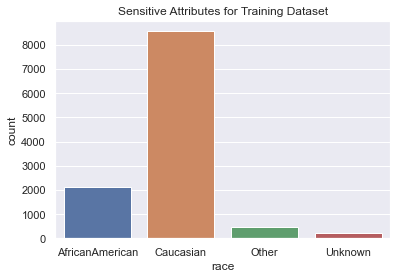
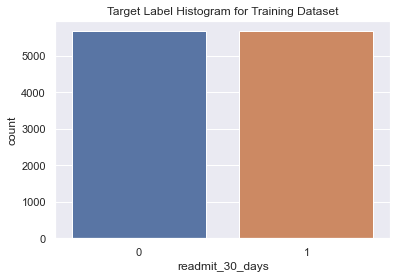
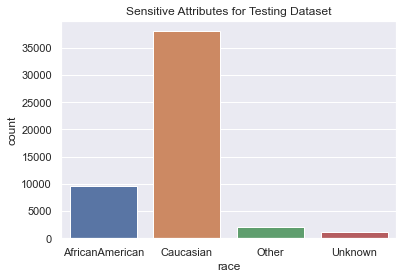
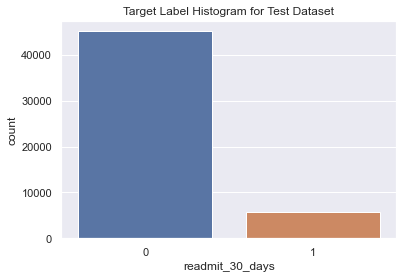
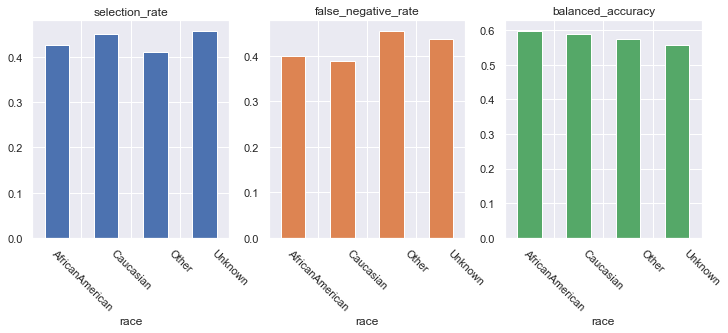

In [107]:
display.HTML(html_modelcard)

# Discussion and conclusion

In this tutorial we have explored in depth a health care scenario through all stages of the AI lifecycle except the model deployment stage. We have seen how fairness-related harms can arise at the stage of task definition, data collection, model training, and model evaluation. We have also seen how to use a variety of tools and practices, such as datasheets for datasets, Fairlearn, and model cards.

Once the model is deployed, it is important to continue monitoring the key metrics to assess any performance difference as well as the potential for fairness related harms. As you learn more about how the model is used, you may need to revise the fairness metrics, update the model, consider additional sensitive features, update the task definition, or collect new data.

Although we used a variety of software tools, fairness is a sociotechnical challenge, so mitigations cannot be purely technical, and need to be supported by processes and practices, including government regulation and organizational incentives.

If you would like to learn more about fairness of AI systems, or to contribute to Fairlearn, we welcome you to join our community. Fairlearn is built and maintained by contributors with a variety of backgrounds and expertise.

Further resources can also be found [on our website](https://fairlearn.org/main/user_guide/further_resources.html).